In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.debugger import Tracer
import pandas       as pd
import numpy        as np
import scipy        as spy
import scipy.signal as sc
import matplotlib.pyplot   as plt
from spectrum import *
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
from scipy.fftpack import fft

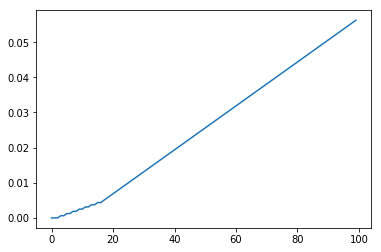

In [2]:
"""Read data into x,y and z"""
df = pd.read_csv('TEST_DATA/63965.csv')

time = df["Timestamp"]

plt.plot(time[0:100]) # There is an issue in the begining of the dataset
plt.show()

cut = 20 # Cut 20 samples
    
x = df["X-Axis"][cut:]
y = df["Y-Axis"][cut:]
z = df["Z-Axis"][cut:]




In [3]:
"""FFT script"""

def amplitude_sepctrum(x, fs):
    T = 1.0 / fs
    N = x.shape[0]
    fft_x = fft(x)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    
    return xf,  2.0/N * np.abs(fft_x[0:N//2])

"""Reample to get better integration results"""

def up_sample(x, N):
    Ns = x.shape[0]*N
    x = spy.signal.resample(x, Ns)
    return x

"""Filter script"""

def filter_signal(x, f_cutoff, fs):
    pad = np.int(x.shape[0]/2)
    Nf = 4 # Filter order
    nyq = fs/2.
    Wn = f_cutoff/nyq
#     print(Wn)
    sos = spy.signal.butter(Nf, Wn, btype='high', analog=False, output='sos')

    x_padded = np.pad(x, (pad,pad), 'reflect') ## Edge pad signals to eliminate filter transition response
    xf = spy.signal.sosfilt(sos, x_padded)
    xf = xf[pad:-pad] # Remove paded values
    
    return xf

"""Integrate script"""
def integrate_accel(x, fs):
    velocity     = spy.integrate.cumtrapz(x)/fs
    velocity = np.insert(velocity, 0, velocity[0])
    displacement = spy.integrate.cumtrapz(velocity)/fs
    displacement = np.insert(displacement, 0, displacement[0])    
    nn = displacement.shape[0]
    t = np.linspace(0, nn, nn, endpoint=False)/fs
    return x, velocity, displacement, t
    



In [4]:
fs = 1600.
N = 10 ## Upsample N times
fs = fs*N
x = up_sample(x, N)
y = up_sample(y, N)
z = up_sample(z, N)

f_cutoff  = 10; 

x, Ix, IIx, t = integrate_accel(x, fs)
x = filter_signal(x, f_cutoff, fs)
Ix = filter_signal(Ix, f_cutoff, fs)
IIx = filter_signal(IIx, f_cutoff, fs)


y, Iy, IIy, t = integrate_accel(y, fs)
y = filter_signal(y, f_cutoff, fs)
Iy = filter_signal(Iy, f_cutoff, fs)
IIy = filter_signal(IIy, f_cutoff, fs)


z, Iz, IIz, t = integrate_accel(z, fs)
z = filter_signal(z, f_cutoff, fs)
Iz = filter_signal(Iz, f_cutoff, fs)
IIz = filter_signal(IIz, f_cutoff, fs)



/home/bostjand/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/bostjand/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


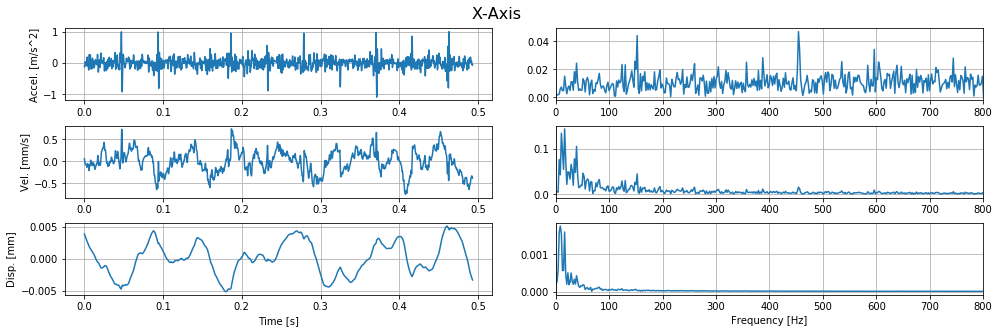

In [5]:
""" The results for x direction"""
fig = plt.figure(figsize=(15,5))
fig.suptitle('X-Axis', fontsize=16)
plt.subplot(3,2,1)
plt.plot(t, x)
plt.grid()
plt.ylabel("Accel. [m/s^2]")

plt.subplot(3,2,2)
freq, FX = amplitude_sepctrum(x, fs)
plt.plot(freq, FX)
plt.xlim((0,800))
plt.grid()


## Velocity
plt.subplot(3,2,3)
plt.plot(t, Ix*1000)
plt.grid()
plt.ylabel("Vel. [mm/s]")
plt.subplot(3,2,4)
freq, FIX = amplitude_sepctrum(Ix, fs)
plt.plot(freq, FIX*1000)
plt.xlim((0,800))
plt.grid()

## Displacement
plt.subplot(3,2,5)
plt.plot(t, IIx*1000)
plt.grid()
plt.ylabel("Disp. [mm]")
plt.xlabel('Time [s]')
plt.subplot(3,2,6)
freq, FIIX = amplitude_sepctrum(IIx, fs)
plt.plot(freq, FIIX*1000)
plt.xlim((0,800))
plt.grid()
plt.xlabel('Frequency [Hz]')


plt.subplots_adjust(top=0.92, bottom=0.18, left=0.1, right=0.95, hspace=0.35,
                    wspace=0.15)

# fig.savefig("16_MARCH_2019/75926_Xaxis.pdf", bbox_inches='tight')
# mpld3.display()

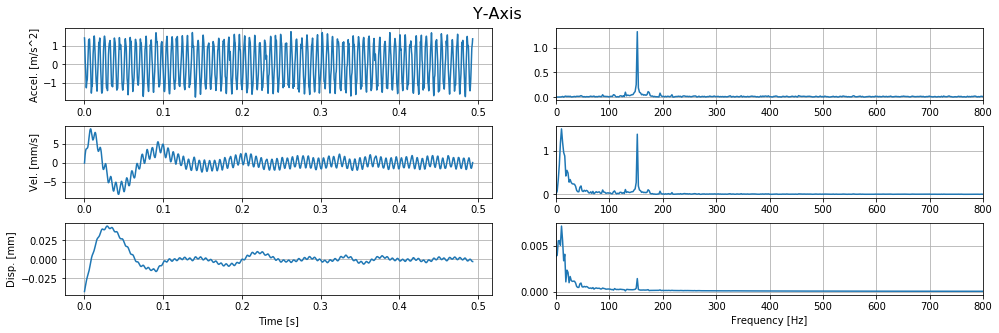

In [6]:
""" The results for y direction"""
fig = plt.figure(figsize=(15,5))
fig.suptitle('Y-Axis', fontsize=16)
plt.subplot(3,2,1)
plt.plot(t, y)
plt.grid()
plt.ylabel("Accel. [m/s^2]")

plt.subplot(3,2,2)
freq, FY = amplitude_sepctrum(y, fs)
plt.plot(freq, FY)
plt.xlim((0,800))
plt.grid()


## Velocity
plt.subplot(3,2,3)
plt.plot(t, Iy*1000)
plt.grid()
plt.ylabel("Vel. [mm/s]")
plt.subplot(3,2,4)
freq, FIY = amplitude_sepctrum(Iy, fs)
plt.plot(freq, FIY*1000)
plt.xlim((0,800))
plt.grid()

## Displacement
plt.subplot(3,2,5)
plt.plot(t, IIy*1000)
plt.grid()
plt.ylabel("Disp. [mm]")
plt.xlabel('Time [s]')
plt.subplot(3,2,6)
freq, FIIY = amplitude_sepctrum(IIy, fs)
plt.plot(freq, FIIY*1000)
plt.xlim((0,800))
plt.grid()
plt.xlabel('Frequency [Hz]')


plt.subplots_adjust(top=0.92, bottom=0.18, left=0.1, right=0.95, hspace=0.35,
                    wspace=0.15)

# fig.savefig("16_MARCH_2019/75926_Yaxis.pdf", bbox_inches='tight')

# mpld3.display()


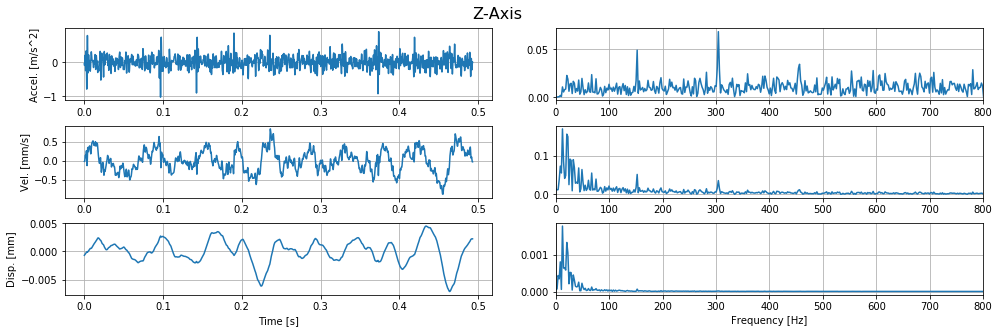

In [7]:
""" The results for z direction"""
fig = plt.figure(figsize=(15,5))
fig.suptitle('Z-Axis', fontsize=16)

plt.subplot(3,2,1)
plt.plot(t, z)
plt.grid()
plt.ylabel("Accel. [m/s^2]")

plt.subplot(3,2,2)
freq, FZ = amplitude_sepctrum(z, fs)
plt.plot(freq, FZ)
plt.grid()
plt.xlim((0,800))



## Velocity
plt.subplot(3,2,3)
plt.plot(t, Iz*1000)
plt.grid()
plt.ylabel("Vel. [mm/s]")
plt.subplot(3,2,4)
freq, FIZ = amplitude_sepctrum(Iz, fs)
plt.plot(freq, FIZ*1000)
plt.grid()
plt.xlim((0,800))


## Displacement
plt.subplot(3,2,5)
plt.plot(t, IIz*1000)
plt.grid()
plt.ylabel("Disp. [mm]")
plt.xlabel('Time [s]')
plt.subplot(3,2,6)
freq, FIIZ = amplitude_sepctrum(IIz, fs)
plt.plot(freq, FIIZ*1000)
plt.xlim((0,800))
plt.grid()
plt.xlabel('Frequency [Hz]')


plt.subplots_adjust(top=0.92, bottom=0.18, left=0.1, right=0.95, hspace=0.35,
                    wspace=0.15)

# fig.savefig("16_MARCH_2019/75926_Zaxis.pdf", bbox_inches='tight')


# mpld3.display()
